# Занятие 2: Работа с PyMol

### Лев Мазаев

In [1]:
import xmlrpc.client as xmlrpclib
import time
cmd = xmlrpclib.ServerProxy('http://localhost:9123')
from IPython.display import Image, HTML

### Sculpting Demo

In [2]:
cmd.do('''
ray 1000, 750
png sculpting.png
''')

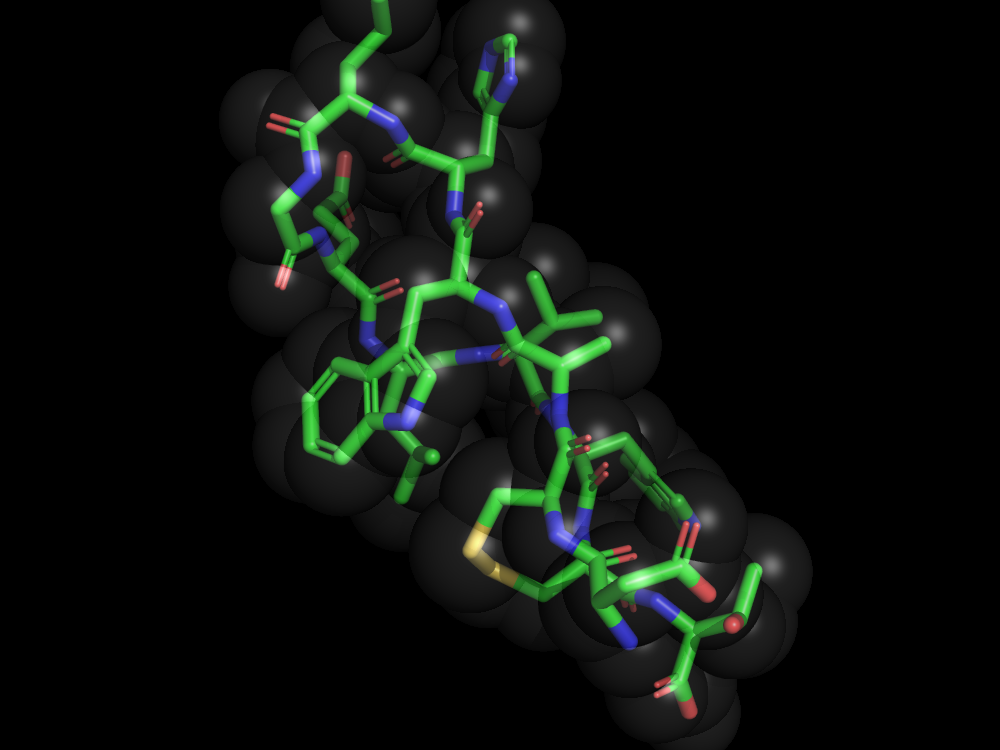

In [3]:
Image('sculpting.png')

### Водородные связи между белком и лигандом

In [4]:
cmd.do('''
reinitialize
fetch 1LMP
''')

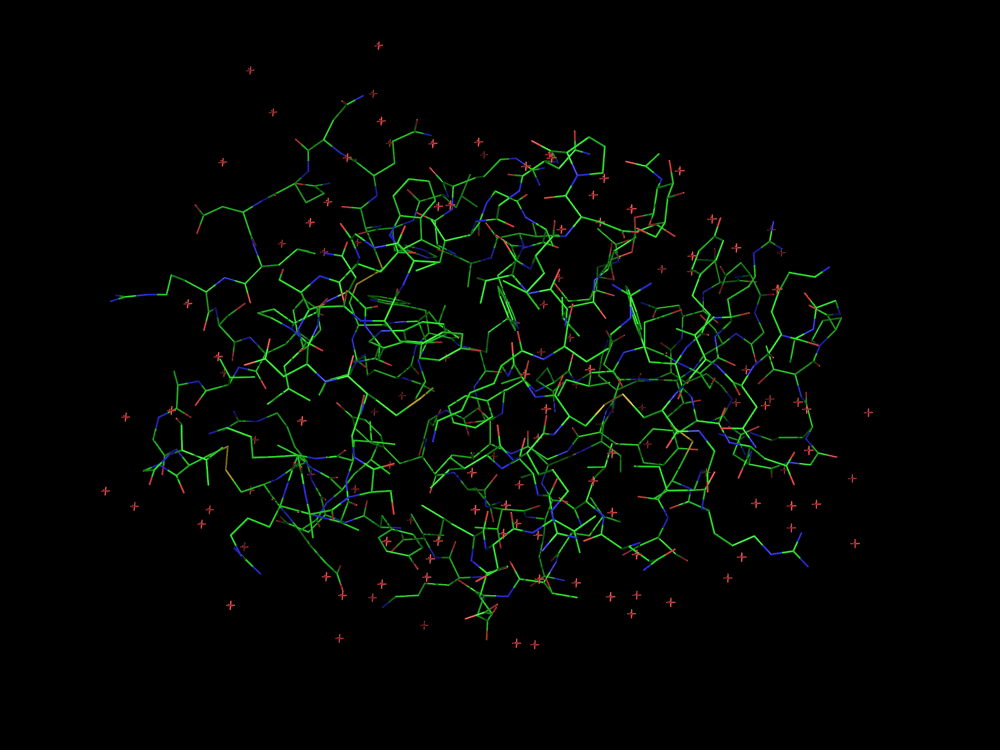

In [5]:
cmd.do('''
orient
ray 1000, 750
png img.png
''')
time.sleep(0.1)
Image('img.png')

Посмотрим где тут лиганд, а где белок.

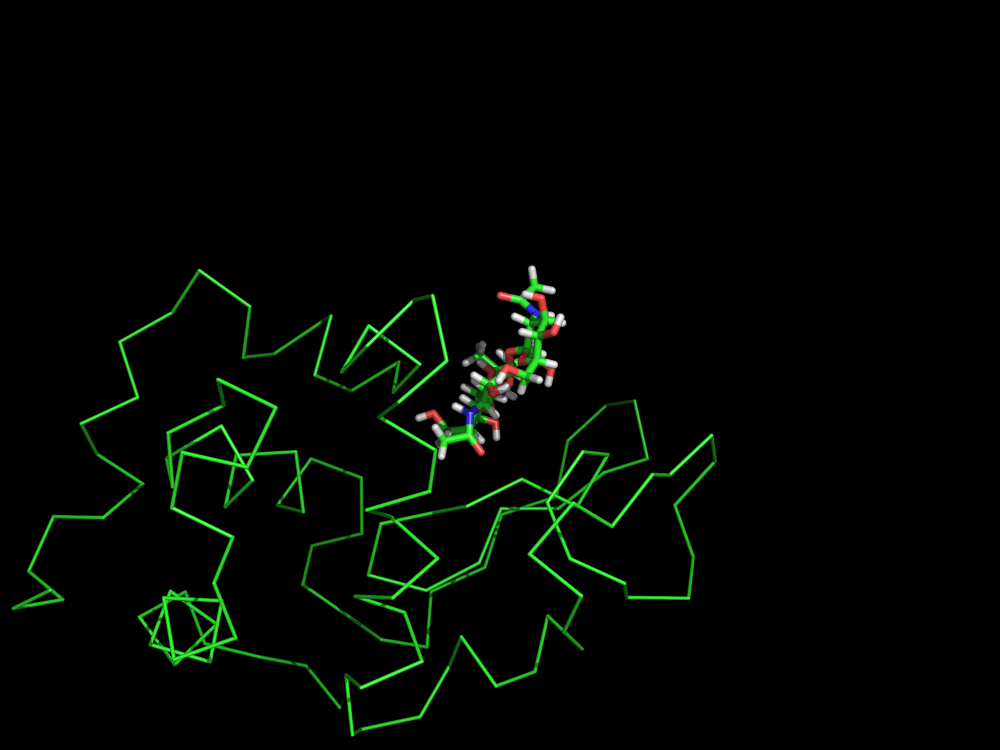

In [6]:
cmd.do('''
remove solvent
h_add
hide everything
show ribbon, polymer
show sticks, organic
center organic
ray 1000, 750
png img.png
''')
time.sleep(0.2)
Image('img.png')

Белок в данном случае показан лентой, лиганд - sticks отображением.

Попробуем отобразить водородные связи (расстояние до 3.2 ангстрем).

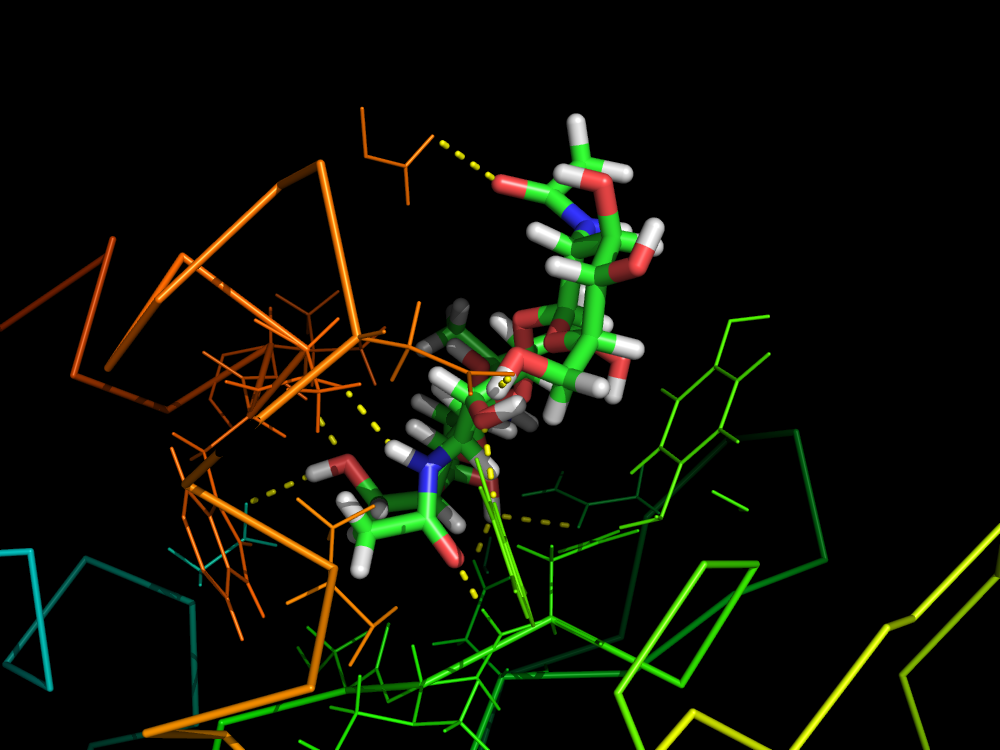

In [7]:
cmd.do('''
sel lig, organic
hide everything
util.chainbow polymer
show ribbon, polymer
show lines, polymer within 5 of lig
show sticks, lig
dist hbonds, polymer, lig, 3.2, mode=2
enable hbonds
hide labels, hbonds
show dashes, hbonds
center lig
origin lig
zoom lig, 3
ray 1000, 750
png img.png
''')
time.sleep(0.2)
Image('img.png')

### Мутация в белке для потери связи с лигандом

Попробуем отобразить все аминокислотные остатки на расстоянии не более 3.2 ангстрем от лиганда, и посмотрим какую мутацию можно провести.

In [8]:
cmd.do('''
hide everything
sel env, br. polymer within 3.2 of lig
show sticks, lig
show lines, env
label n. CA and env, "(%s, %s)" % (resn, resi)
show dashes, hbonds
show labels, hbonds
set label_size, 30
''')

In [10]:
cmd.do('''
show sticks, i. 52
color purple, i. 52
show sticks, i. 59
color yellow , i. 59
ray
png acids.png
''')

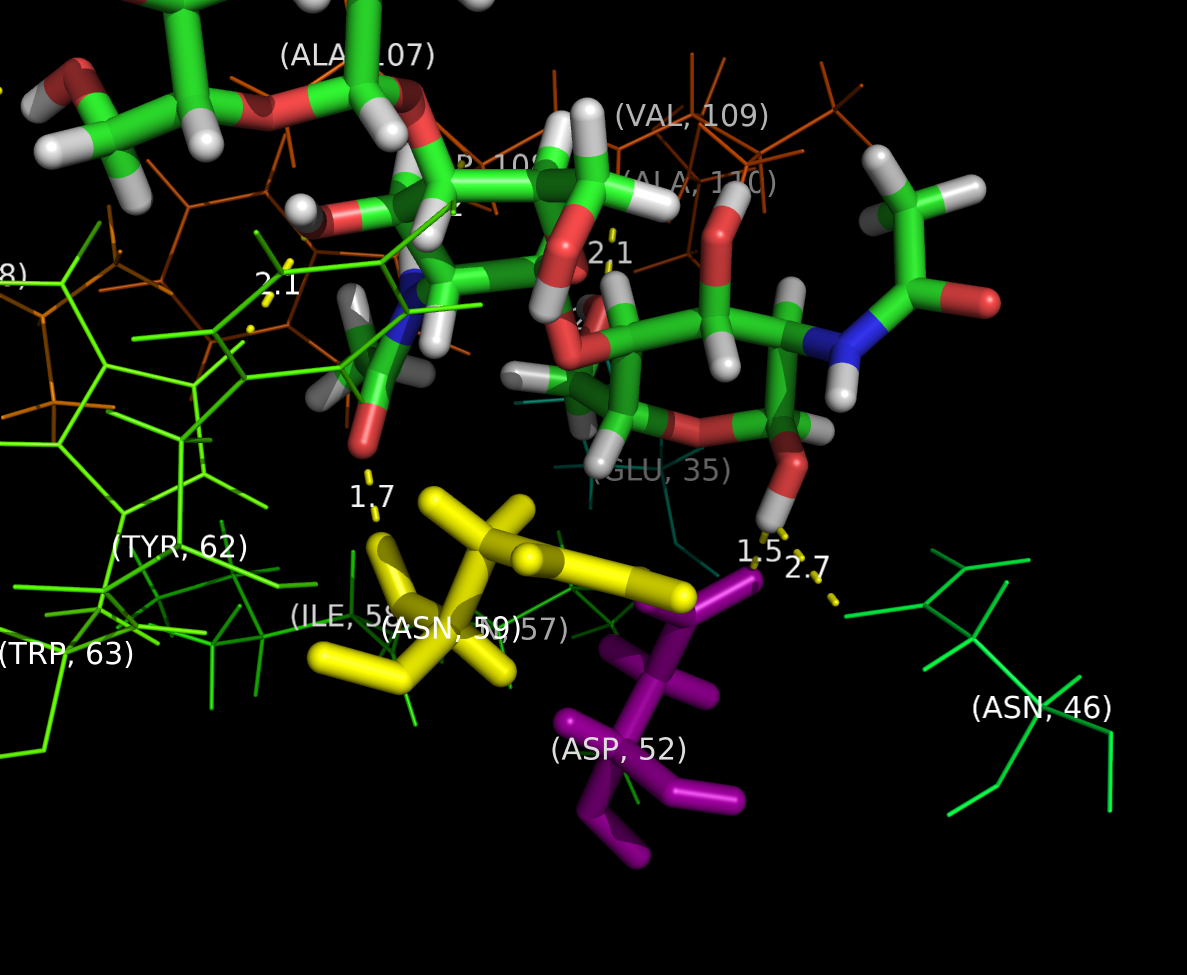

In [11]:
Image('acids.png')

Видим, что наиболее близкие аминокислотные остатки - ASP (аспарагиновая кислота) на 52-ой позиции, и ASN (аспарагин) на 59-ой позиции. В ходе применения различных мутаций, удалось выяснить, что модифицкация 52ASP в 52TRP приводит препятствует размещению здесь лиганда. 

In [12]:
cmd.wizard('mutagenesis')
cmd.do('''
refresh _wizard
cmd.get_wizard().do_select("52/")
cmd.get_wizard().set_mode("TRP")
cmd.get_wizard().apply()
wizard
''')

Что получили после мутации (оставлены только лиганд и 52-й остаток):

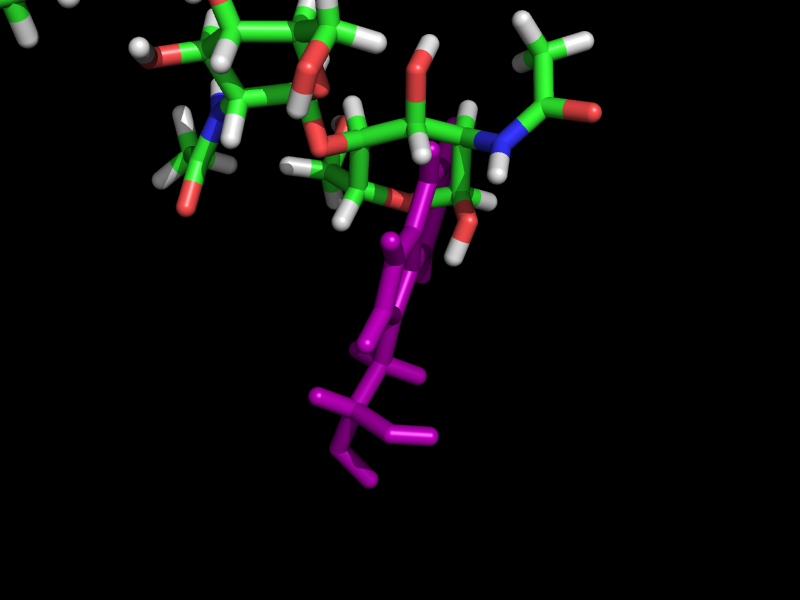

In [13]:
cmd.do('''
hide everything
show sticks, lig
show sticks, i. 52
color purple, i. 52
center i. 52
ray 800, 600
png img.png
save 1lmp_mod.pdb, all
''')
time.sleep(0.2)
Image('img.png')

### Анимационный ролик

Белым визуализируем лиганд, фиолетовым - мутированный остаток, жёлтым - оригинальный остаток, голубым - мутированный белок, зелёным - оригинальный белок.

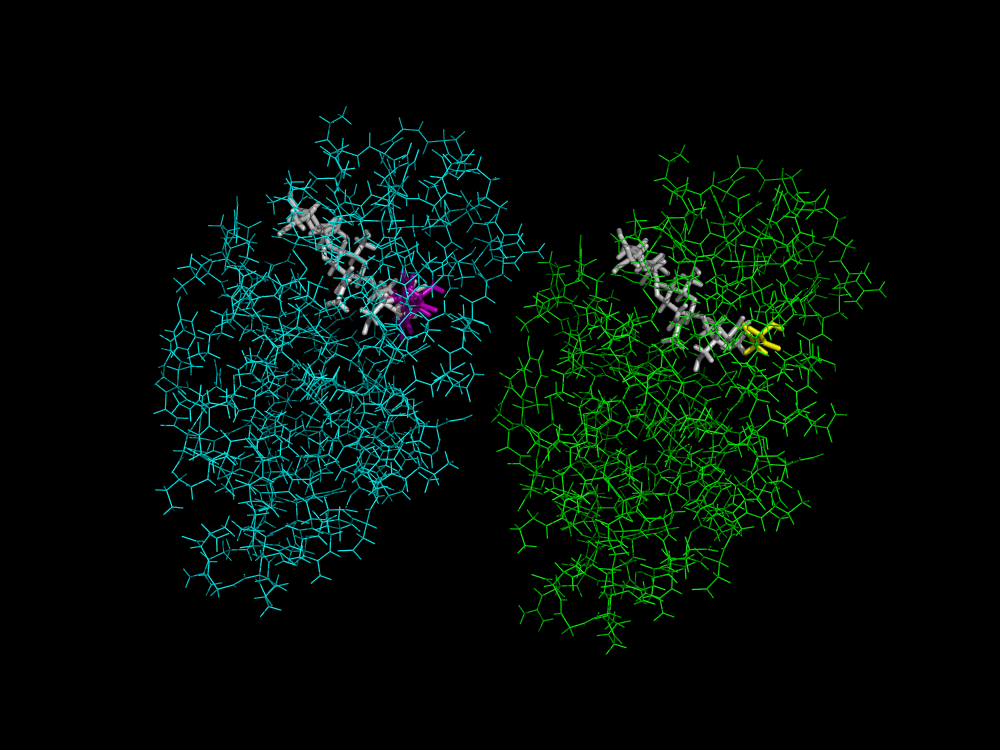

In [14]:
cmd.do('''
reinitialize
load 1lmp.cif, ori
load 1lmp_mod.pdb, mut
remove solvent
h_add

translate [30, 0, 0], ori
orient

hide everything
sel lig1, ori and organic
sel lig2, mut and organic
sel mp1, i. 52 & ori
sel mp2, i. 52 & mut
sel ms, mp* + lig* within 5 of mp*

show sticks, lig* or mp*
show lines, (ori | mut) & (!lig* | !mp*)
color yellow, mp1
color purple, mp2
color white, lig*
color cyan, mut & !(mp* | lig*)
color green, ori & !(mp* | lig*)
set transparency, 0.5
orient

ray 1000, 750
png img.png
''')
time.sleep(0.5)
Image('img.png')

In [15]:
cmd.do('''
set matrix_mode, 1
set movie_auto_interpolate, 1

mset 1x540

frame1
mview store
mview store, object=ori

frame 60
orient organic
mview store

frame 120
orient mp2
mview store

frame 180
orient organic
mview store

frame 240
orient mp1
mview store
mview store, object=ori

frame 300
orient lig2
mview store

frame 480
orient ms
super ori, mut
mview store
mview store, object=ori

frame 540
orient
mview store

mplay
''')

In [ ]:
cmd.do('''
set ray_trace_frames, 1
set antialias, 2
mpng ./movie/frm
''')

In [16]:
HTML('<video controls alt="PyMol" src="./movie/out.mp4" type="video/mp4">')

### Присоединение флуоресцентной метки TAMRA

In [17]:
# Пересохранение в pdb
cmd.do('''
reinitialize
load tamra.sdf
save tamra.pdb, tamra
''')

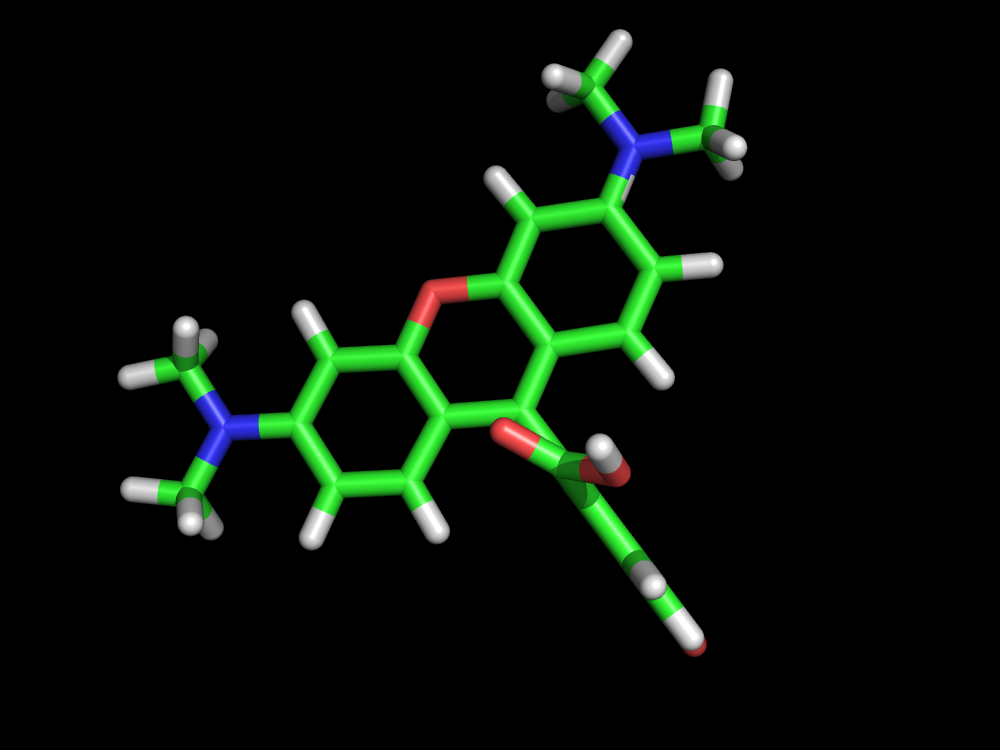

In [18]:
cmd.do('''
reinitialize
load tamra.pdb
load 1lmp.cif
remove solvent
h_add

as sticks, tamra
as sticks, polymer
zoom tamra
ray 1000, 750
png img.png
''')
Image('img.png')

Сложноэфирная связь: R1-COOH + R2-OH → R1-COO-R2 + H2O
У этой метки есть COOH конец, соответственно она входит в связь как кислота. Нужна аминокислотая с OH-группой, которая ведёт себя как спирт при образовании связи. Такие кислоты: серин (S), треонин (T), тирозин (Y). Найдём какую-нибудь из таких кислот в цепи так, чтобы доступ к OH-группе не был затруднён. Например, это треонин в 43-й позиции.

In [19]:
cmd.do('''
sel tbond, n. O in tamra within 2 of n. H in tamra
sel pbond, n. OG1 in resi 43
fuse tbond, pbond
orient pbond
torsion -50
''')

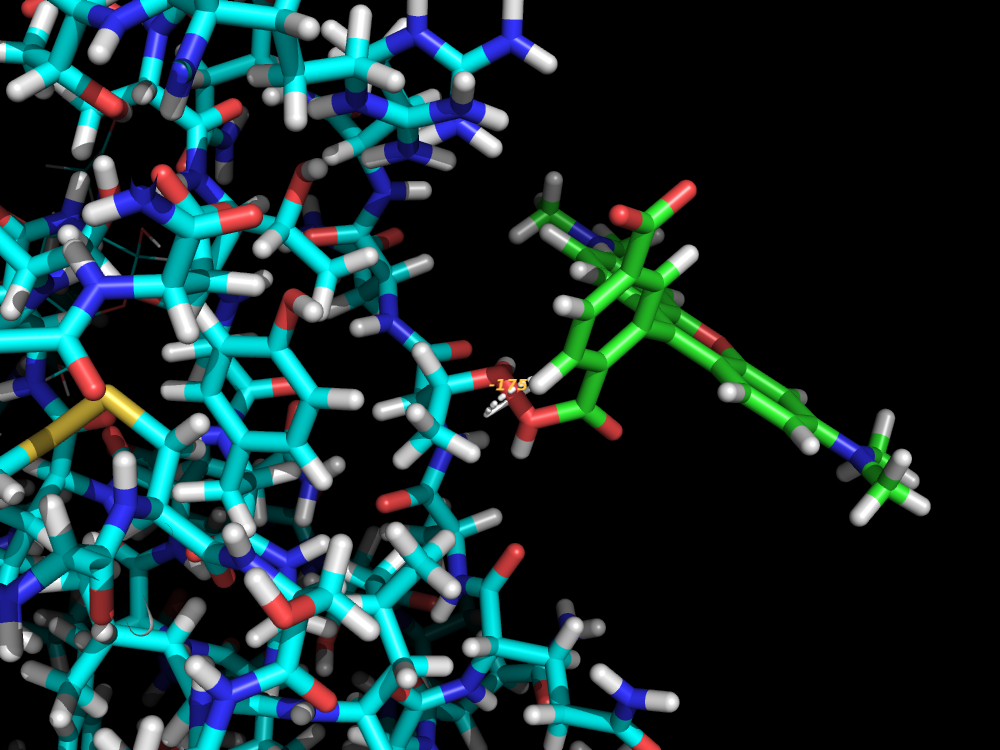

In [20]:
cmd.do('''
ray 1000, 750
png img.png
''')
time.sleep(0.5)
Image('img.png')

### Построение полиаланиновой альфа-спирали

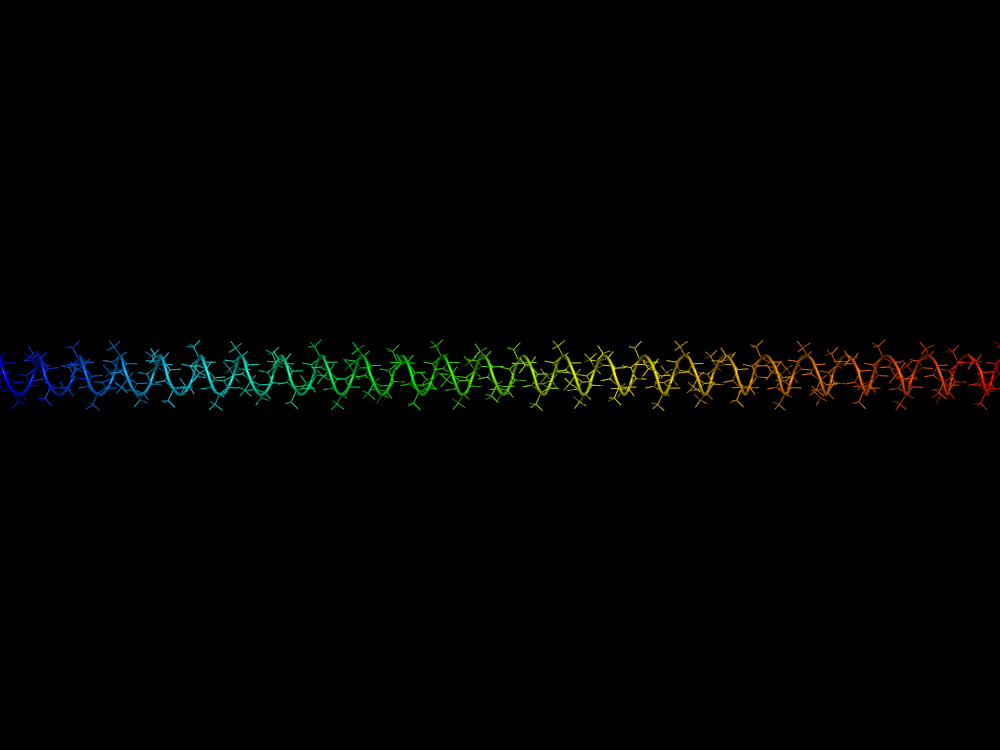

In [22]:
cmd.do('''
reinitialize
fragment ala
edit ala/C
python
for x in range(1, 100):
    editor.attach_amino_acid("pk1","ala", ss=1)
python end
orient
hide everything
util.chainbow polymer
show lines
show cartoon, n. ca+c+n
ray 1000, 750
png img.png
''')
time.sleep(0.2)
Image('img.png')